In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ksource_py as ks

In [2]:
# Abrir lista de particulas

folder = "1_guia_n_knn" # "Ftes_tracks"
tracks = folder+"/D_tracks.ssv" # "/GF12p_n"
trasl = None # [118.5497276, -102.897199, 5.0]
rot = [0., 0., np.pi] # [0.0, 0.0, -158*np.pi/180.0]
x2z = False

set_params = True
plist = ks.PList("SSV", tracks, trasl=trasl, rot=rot, switch_x2z=x2z, set_params=set_params)

Reading file 1_guia_n_knn/D_tracks.ssv ...
Done
I = 6187.010252216818
p2 = 4152.861553909106
N = 89849


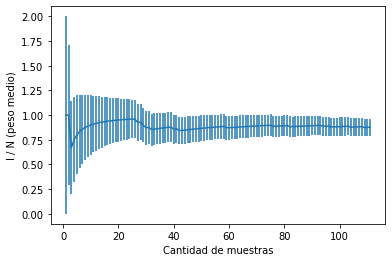

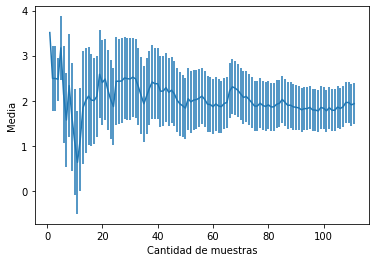

In [8]:
# Evaluar estadistica

Emin = 1e-7
dzmax = np.sqrt(1-0.01**2)
box = ks.BoxMask([Emin,None,None,None,None,None,dzmax], None)

parts,ws = plist.get()
tracks = ks.TracksStats(parts, ws, box)

N,mn,err = tracks.intensity(steps=100)
plt.show()

N,mn,err = tracks.mean(var=1, steps=100)
plt.show()

In [3]:
# Crear KSource

J = 3.669E+15
#metric = ks.SepVarMetric(ks.Lethargy(10), ks.SurfXY(0), ks.Polar())
metric = ks.SepVarMetric(ks.Lethargy(10), ks.Guide(7, 20, 2020, -92900), ks.Isotrop())
s = ks.KSource(plist, metric, bw="silv", J=J)

In [4]:
# Guardar KSource

filename = tracks[:-4]+"_source.txt"
bwfilename = tracks[:-4]+"_bw_knn.txt"
s.bw = np.zeros((0,0))
s.save(filename, bwfilename)

### Optimizacion de BW

In [32]:
# Metodo de Silverman

s.bw_method = "silv"
N = 1E4
s.fit(N, N_tot=2991283)
s.save_bw(tracks[:-4]+"_bw_silv.txt")

Usando 10000 particulas para entrenamiento
Calculando bw ... 
Hecho
Optimal bw (silv) = [2.89679190e-01 1.26057189e+02 3.26930575e+00 6.03387254e-03
 6.03387254e-03 6.03387254e-03]


Usando 10000 particulas para entrenamiento
Calculando bw ... 
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.9s
[Parallel(

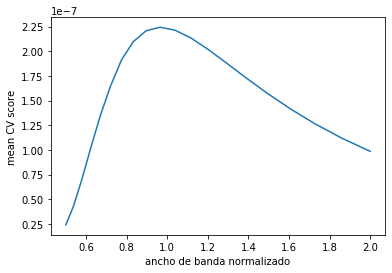

Hecho
Optimal bw (mlcv) = [1.98279604e-01 8.62836212e+01 2.23777431e+00 4.13006491e-03
 4.13006491e-03 4.13006491e-03]


In [7]:
# Metodo de Max Likelihood Cross Validation

s.bw_method = "mlcv"
N = 1E4
s.fit(N, N_tot=s.plist.N, steps=20, max_fact=2, shift=.5)
s.save_bw(tracks[:-4]+"_bw_mlcv.txt")

In [6]:
# Metodo de K Nearest Neighbours

s.bw_method = "knn"
N = 1e5
s.fit(N)#, N_tot=100000)#2991283)
s.save_bw(tracks[:-4]+"_bw_knn.txt")

print("Mean bw:")
print(s.bw.mean(axis=0))

Usando 89849 particulas para entrenamiento
Calculando bw ... 
batch = 1 / 8
batch = 2 / 8
batch = 3 / 8
batch = 4 / 8
batch = 5 / 8
batch = 6 / 8
batch = 7 / 8
batch = 8 / 8
Hecho
Optimal bw (knn) = [[2.557e-01 1.098e+02 2.845e+00 5.463e-03 5.463e-03 5.463e-03]
 [2.416e-01 1.037e+02 2.688e+00 5.161e-03 5.161e-03 5.161e-03]
 [2.512e-01 1.079e+02 2.795e+00 5.366e-03 5.366e-03 5.366e-03]
 ...
 [2.449e-01 1.052e+02 2.726e+00 5.233e-03 5.233e-03 5.233e-03]
 [2.559e-01 1.099e+02 2.847e+00 5.467e-03 5.467e-03 5.467e-03]
 [1.829e-01 7.853e+01 2.035e+00 3.907e-03 3.907e-03 3.907e-03]]
Mean bw:
[3.071e-01 1.319e+02 3.417e+00 6.561e-03 6.561e-03 6.561e-03]


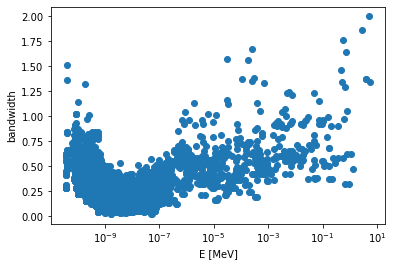

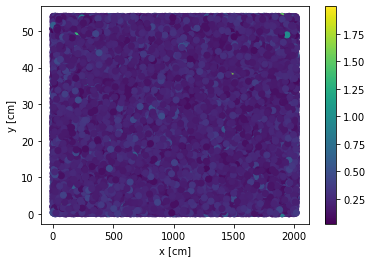

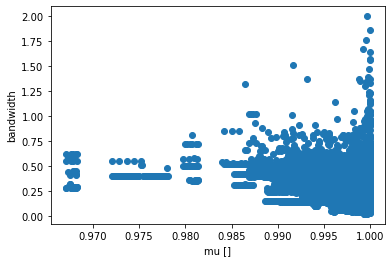

In [11]:
if N>s.plist.N: N = s.plist.N
bws = (s.bw / s.metric.std(vecs=s.vecs))[:,0]

Es = s.metric.E.inverse_transform(s.vecs[:N,0])
plt.plot(Es, bws, 'o')
plt.ylabel("bandwidth")
plt.xlabel("E [MeV]")
plt.xscale("log")
plt.show()

xs = s.vecs[:N,1]
ys = s.vecs[:N,2]
plt.scatter(xs, ys, c=bws)
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.show()

mus = s.vecs[:N,5]
plt.plot(mus, bws, 'o')
plt.ylabel("bandwidth")
plt.xlabel("mu []")
plt.show()